In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
%matplotlib inline

## Leitura dataset

In [2]:
dataset = pd.read_csv('coverage-dataset.csv', sep=';')
dataset.head(5)

,Name,CountInput,CountLine,CountLineBlank,CountLineCode,CountLineCodeDecl,CountLineCodeExe,CountLineComment,CountOutput,CountPath,...,CyclomaticStrict.1,Essential.1,Knots.1,MaxEssentialKnots.1,MaxNesting.1,MinEssentialKnots.1,RatioCommentToCode.1,EdgeCoverage,PrimePathCoverage,Unnamed: 50
0,org.biojava.nbio.alignment.GuideTree.getAllPai...,2,13,0,8,3,5,5,3,2,...,1,1,0,0,0,0,0.00,"1,0000","0,8000",NaN
1,org.biojava.nbio.alignment.GuideTree.getDistan...,3,14,0,9,2,5,5,3,3,...,1,1,0,0,0,0,0.00,"1,0000","0,7143",NaN
2,org.biojava.nbio.alignment.GuideTree.getScoreM...,4,15,0,10,2,6,5,5,3,...,1,1,0,0,0,0,0.00,"1,0000","0,7000",NaN
3,org.biojava.nbio.alignment.SimpleGapPenalty.se...,2,7,0,4,1,2,3,3,1,...,2,1,1,0,1,0,0.29,"1,0000","1,0000",NaN
4,org.biojava.nbio.alignment.SimpleGapPenalty.se...,2,7,0,4,1,2,3,3,1,...,2,1,1,0,1,0,0.29,"1,0000","1,0000",NaN


## Pré-processamento

In [3]:
# Remove ultima coluna vazia
dataset = dataset.iloc[:,:-1]

# Remove NaN
dataset = dataset.dropna()

# Converte valores de cobertura em float
dataset.iloc[:,-1] = dataset.iloc[:,-1].apply(lambda ppc: float(ppc.replace(',', '.')))
dataset.iloc[:,-2] = dataset.iloc[:,-2].apply(lambda ec: float(ec.replace(',', '.')))

# Remove valores de cobertura zerados
dataset = dataset[dataset['EdgeCoverage'] > 0]
dataset = dataset[dataset['PrimePathCoverage'] > 0]

## Funções uteis

In [4]:
from sklearn.preprocessing import StandardScaler

k = 10
metricas_erro = [
    'r2', 'max_error', 'neg_mean_absolute_error',
    'neg_mean_squared_error', 'neg_root_mean_squared_error',
    'neg_mean_squared_log_error', 'neg_median_absolute_error'
]
previsores = [
    # Método testado
    'CountInput','CountLine','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','EdgeCoverage',
    
    # Método de teste
    'CountInput.1','CountLine.1','CountLineBlank.1',
    'CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountOutput.1','CountStmt.1', 'CountStmtDecl.1',
    'CountStmtExe.1','Cyclomatic.1'
]

def escalonador(dados):
    scaler = StandardScaler()
    return scaler.fit_transform(dados)

def evaluate(previsores, classificador, d = dataset, k=10):
    ppc = d['PrimePathCoverage'].values
    previsores_content = d[previsores].values
    resultados = cross_validate(
            classificador, 
            previsores_content, 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )
    
    print('-----< SEM ESCALONAMENTO >-----')
    print('Mean Abs Error: ', abs(resultados['test_neg_mean_absolute_error'].mean()))
    print('Mean Sqr Error: ', abs(resultados['test_neg_mean_squared_error'].mean()))
    print('Mean Sqr Log Error: ', abs(resultados['test_neg_mean_squared_log_error'].mean()))
    print('Mean Median Error: ', abs(resultados['test_neg_median_absolute_error'].mean()))
    print('R2 Score: ', abs(resultados['test_r2'].mean()))
    print('-----< COM ESCALONAMENTO >-----')
    print('Mean Abs Error: ', abs(resultados_escalonados['test_neg_mean_absolute_error'].mean()))
    print('Mean Sqr Error: ', abs(resultados_escalonados['test_neg_mean_squared_error'].mean()))
    print('Mean Sqr Log Error: ', abs(resultados_escalonados['test_neg_mean_squared_log_error'].mean()))
    print('Mean Median Error: ', abs(resultados_escalonados['test_neg_median_absolute_error'].mean()))
    print('R2 Score: ', abs(resultados_escalonados['test_r2'].mean()))


def evaluate_metrics(classificador, d = dataset):
    ppc = d['PrimePathCoverage'].values
    importance_dataset = pd.DataFrame(
            [0]*len(previsores),
            index=previsores,
            columns=['importance']
    )
    previsores_content = d[previsores].values
    resultados = cross_validate(
            classificador, 
            previsores_content, 
            ppc, 
            cv=k, 
            scoring=metricas_erro,
            return_estimator=True
    )
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro,
            return_estimator=True
    )
    
    print('-----< SEM ESCALONAMENTO >-----')
    #print(resultados)
    for idx,estimator in enumerate(resultados['estimator']):
        feature_importances = pd.DataFrame(estimator.svm.coef_,
                                           index=previsores,
                                           columns=['importance'])
        importance_dataset += feature_importances
 
    #print(importance_dataset) 
    importance_dataset['mean'] = importance_dataset['importance'] / k
    plt.figure(figsize=(10,9))
    plt.title("Feature importance - Random forest - K = 10 - Mean")
    plt.barh(previsores, importance_dataset['mean'].values)
    plt.show()
    
    importance_dataset = pd.DataFrame(
            [0]*len(previsores),
            index=previsores,
            columns=['importance']
    )
    print('\n')
    
    print('-----< COM ESCALONAMENTO >-----')
    for idx,estimator in enumerate(resultados_escalonados['estimator']):
        feature_importances = pd.DataFrame(estimator.coef__,
                                           index=previsores,
                                           columns=['importance'])
        importance_dataset += feature_importances

    importance_dataset['mean'] = importance_dataset['importance'] / k
    print(importance_dataset)
    plt.figure(figsize=(10,9))
    plt.title("Feature importance - Random forest - K = 10 - Mean")
    plt.barh(previsores, importance_dataset['mean'].values)
    plt.show()

## SVR

In [7]:
from sklearn.svm import SVR

## Usando under-sampling

Dataset size:  2167
Média complexidade dataset:  3.446528555431131
Média complexidade dataset balanceado:  5.032764190124596


<AxesSubplot:xlabel='Cyclomatic', ylabel='Count'>

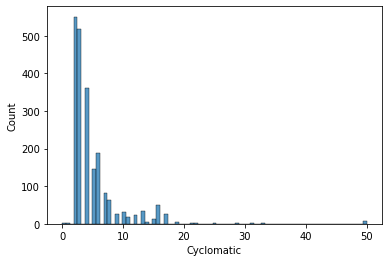

In [5]:
from imblearn.under_sampling import RandomUnderSampler

# usa técnica under-sampling
def under_sampling(d, seed = 0):
    ppc = d['PrimePathCoverage'].values
    rus = RandomUnderSampler(random_state=seed, sampling_strategy='majority')
    X_res, y_res = rus.fit_resample(d['Name'].values.reshape(-1,1), d['Cyclomatic'].values)
    d['Selected'] = d['Name'].apply(lambda name: name in X_res)
    dataset_filtered = d[d['Selected']]
    dataset_filtered = dataset_filtered.drop('Selected', axis=1)
    d = d.drop('Selected', axis=1)
    
    return dataset_filtered

dataset_filtered = under_sampling(dataset, 0)
print('Dataset size: ', dataset_filtered.shape[0])
print('Média complexidade dataset: ', dataset['Cyclomatic'].mean())
print('Média complexidade dataset balanceado: ', dataset_filtered['Cyclomatic'].mean())
sns.histplot(dataset_filtered['Cyclomatic'])

In [9]:
#evaluate_metrics(SVR(), dataset_filtered)
evaluate([
    'CountOutput',
    'EdgeCoverage',
    'Knots',
    'CountStmtDecl',
    'CountLineCodeDecl'
], SVR(), dataset_filtered)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


In [8]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified', 
    'CyclomaticStrict', 
    'CountInput', 
    'CountOutput',
    'EdgeCoverage',
    'CountStmtExe.1'
], SVR(), dataset_filtered)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [9]:
evaluate([
    'MaxNesting', 
    'CountPath', 
    'CountStmtExe', 
    'CountInput', 
    'CountOutput',
    'CountStmtExe.1'
], SVR(), dataset_filtered)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


In [10]:
evaluate([
    'CountInput','CountLine','CountOutput','CountPath','CountStmt','CountStmtDecl','Knots',
    'MaxNesting','MinEssentialKnots',
    
    'CountInput.1','CountLine.1','CountLineCodeDecl.1','CountOutput.1','CountStmtDecl.1','CountStmtExe.1'
], SVR(), dataset_filtered)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


In [11]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified',
    'CountOutput',
    'Essential',
    'CountLine',
    'EdgeCoverage'
], SVR(), dataset_filtered)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.181164696960418
Mean Sqr Error:  0.04912120101430165
Mean Sqr Log Error:  0.02071776414148576
Mean Median Error:  0.16854806405620165
R2 Score:  0.3506047430148798
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [12]:
evaluate([
    'CountInput','CountLine','CountLineBlank','CountLineCode','CountLineCodeDecl','CountLineCodeExe',
    'CountLineComment','CountOutput','CountStmt','CountStmtDecl',
    'CountStmtExe','Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential','Knots','MaxEssentialKnots',
    'MaxNesting','MinEssentialKnots',
    
    'CountInput.1','CountLine.1','CountLineBlank.1','CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountLineComment.1','CountOutput.1','CountPath.1','CountPathLog.1','CountStmt.1',
    'CountStmtDecl.1','CountStmtExe.1'
], SVR(), dataset_filtered)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan
